In [10]:
from neucube import Reservoir
from neucube.encoder import Delta
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
import torch

In [11]:
import numpy as np
import pandas as pd

filenameslist = ['sam'+str(idx)+'_eeg.csv' for idx in range(1,61)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/wrist_movement_eeg/'+filename, header=None))

fulldf = pd.concat(dfs)

labels = pd.read_csv('./example_data/wrist_movement_eeg/tar_class_labels.csv', header=None)
y = labels.values.flatten()

feat_names = pd.read_csv('./example_data/wrist_movement_eeg/feature_names_eeg.txt', header=None).values.flatten()
brain_coordinates = pd.read_csv('./example_data/wrist_movement_eeg/brain_coordinates.csv', header=None).values
eeg_mapping = pd.read_csv('./example_data/wrist_movement_eeg/eeg_mapping.csv', header=None).values

In [12]:
X = torch.tensor(fulldf.values.reshape(60,128,14))
encoder = Delta(threshold=0.8)
X = encoder.encode_dataset(X)
y = labels.values.flatten()

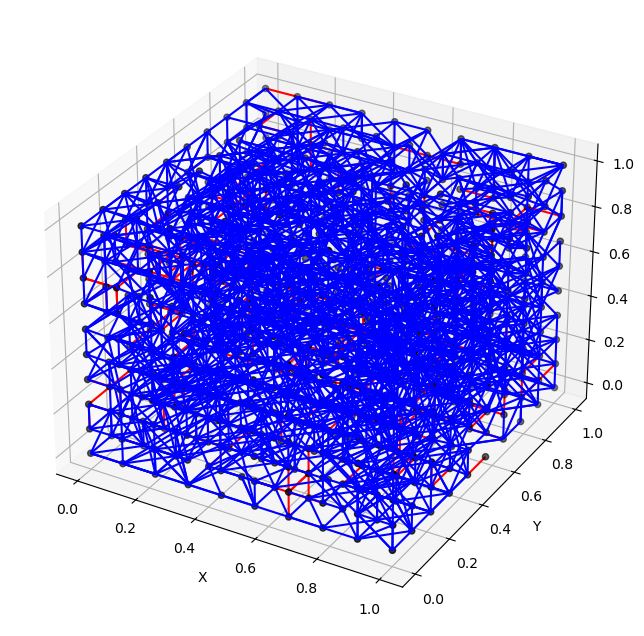

In [14]:
from neucube.visualise import spike_raster, plot_connections
res = Reservoir(inputs=X.shape[2])
plot_connections(res)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:44<00:00,  1.36it/s]


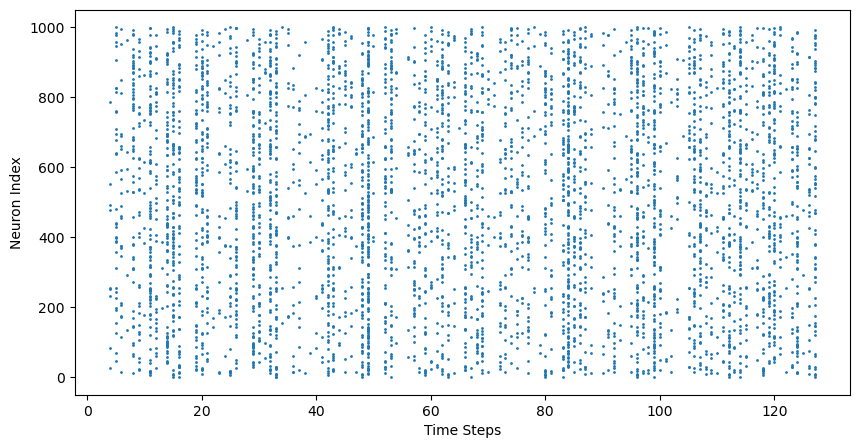

In [16]:
out = res.simulate(X)
spike_raster(out[0])

In [17]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

kf = KFold(n_splits=5, shuffle=True, random_state=123)
y_total, pred_total = [],[]

for train_index, test_index in tqdm(kf.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  res = Reservoir(inputs=14, c=0.4, l=0.169)
  sam =  SpikeCount()
  clf = LogisticRegression(solver='liblinear')
  pipe = Pipeline(res, sam, clf)
  
  pipe.fit(X_train, y_train)
  pred = pipe.predict(X_test)

  y_total.extend(y_test)
  pred_total.extend(pred)

print(accuracy(y_total, pred_total))
print(confusion_matrix(y_total, pred_total))

5it [00:43,  8.74s/it]

0.75
[[15  5  0]
 [ 4 15  1]
 [ 1  4 15]]
